In [5]:
import pandas as pd
import numpy as np
import pickle
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [6]:
with open("Data/train_test_split_revisited.pkl", "rb") as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

In [7]:
# Replace infinities with NaN
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# -----------------------------
# 1️⃣ Define features
# -----------------------------
numeric_features = ['Car_Age', 'Mileage_per_Year', 'Engine', 'Brand_Strength']  # add 'Remaining_Life' if you kept it
binary_features = ['Has_Service_History', 'Is_Premium', 'Is_Family_Car']
categorical_features = [col for col in X_train.columns if col not in numeric_features + binary_features + ['Log_Price']]


# Fill NaNs with median of each column
for col in numeric_features:
    median = X_train[col].median()
    X_train[col].fillna(median, inplace=True)
    X_test[col].fillna(median, inplace=True)



In [8]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# -----------------------------
# 2️⃣ Preprocessor
# -----------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),   # optional, RF does not need scaling
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'  # leave binary columns as is
)

# -----------------------------
# 3️⃣ Build pipeline
# -----------------------------
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# -----------------------------
# 4️⃣ Hyperparameter grid
# -----------------------------
param_grid = {
    'regressor__n_estimators': [200, 500, 800],
    'regressor__max_depth': [None, 20, 25],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['sqrt', 0.5, 0.7]
}

# -----------------------------
# 5️⃣ Randomized Search
# -----------------------------
scoring = {
    'R2':'r2',
    'MAE':'neg_mean_absolute_error',
    'RMSE':'neg_root_mean_squared_error'
}

random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=50,
    cv=5,
    scoring=scoring,
    refit='R2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# -----------------------------
# 6️⃣ Fit model
# -----------------------------
random_search.fit(X_train, y_train)

print("Best params:", random_search.best_params_)
print("Train R²:", random_search.score(X_train, y_train))
print("Test R²:", random_search.score(X_test, y_test))

# -----------------------------
# 7️⃣ Predict and evaluate in £
# -----------------------------
y_pred_log = random_search.predict(X_test)
y_test_actual = np.exp(y_test)
y_pred_actual = np.exp(y_pred_log)

rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
mae = mean_absolute_error(y_test_actual, y_pred_actual)
r2 = r2_score(y_test_actual, y_pred_actual)

print("RMSE (£):", rmse)
print("MAE (£):", mae)
print("R²:", r2)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


Best params: {'regressor__n_estimators': 800, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_features': 0.7, 'regressor__max_depth': 20}
Train R²: 0.9853116675342399
Test R²: 0.8739340341865218
RMSE (£): 1340.0137857252557
MAE (£): 770.2602978678395
R²: 0.9156614907016334


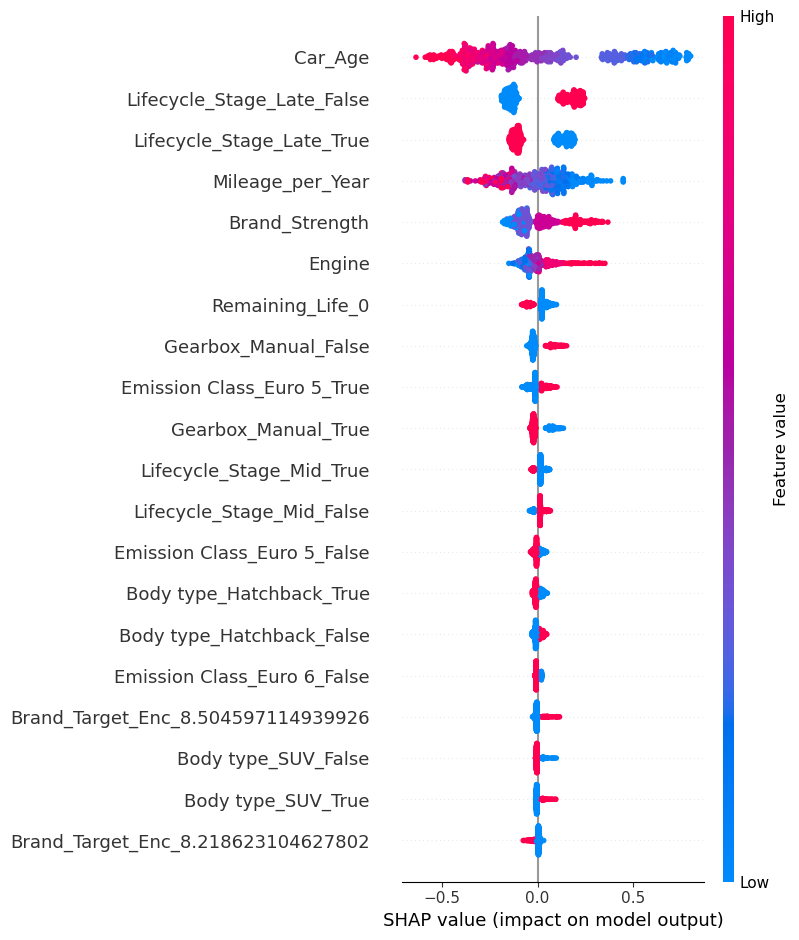

In [9]:
# -----------------------------
# Get fitted pipeline and regressor
# -----------------------------
best_pipeline = random_search.best_estimator_

# Preprocess test data
X_test_preprocessed = best_pipeline.named_steps['preprocessor'].transform(X_test)

# Get trained Random Forest
rf_model = best_pipeline.named_steps['regressor']

# -----------------------------
# SHAP explainer
# -----------------------------
import shap
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_preprocessed)
import pandas as pd

# Numeric features
numeric_features = ['Car_Age', 'Mileage_per_Year', 'Engine', 'Brand_Strength']

# Get ColumnTransformer
preprocessor = best_pipeline.named_steps['preprocessor']

# Get the categorical transformer from ColumnTransformer
# It might be directly OneHotEncoder
categorical_transformer = preprocessor.named_transformers_['cat']

# Get categorical feature names
# If you used OneHotEncoder directly (not a pipeline), do:
categorical_features = categorical_transformer.get_feature_names_out(preprocessor.transformers_[1][2])  
# preprocessor.transformers_[1][2] gives original categorical column names

# Combine numeric + categorical feature names
feature_names = list(numeric_features) + list(categorical_features)

# Convert preprocessed test set to DataFrame
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=feature_names)


# -----------------------------
# SHAP summary plot
# -----------------------------
import matplotlib.pyplot as plt

shap.summary_plot(shap_values, X_test_preprocessed, feature_names=feature_names, max_display=20)


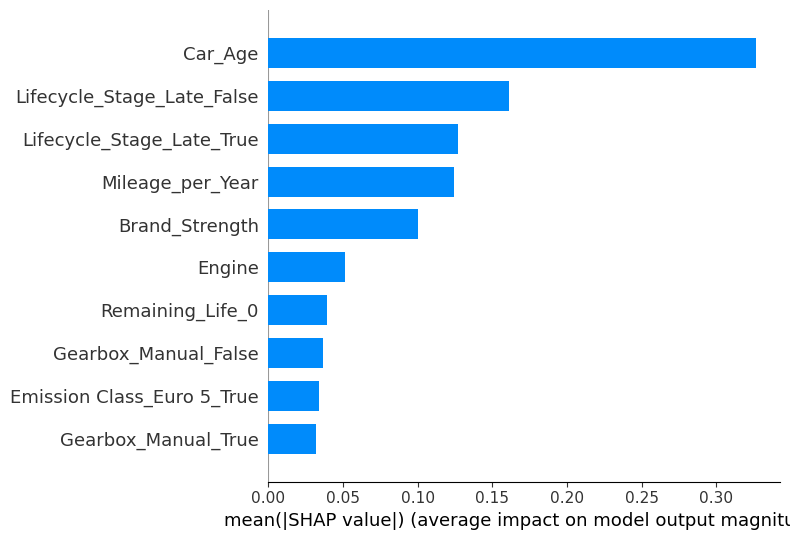

In [10]:
shap.summary_plot(
    shap_values, 
    X_test_preprocessed_df, 
    feature_names=feature_names,
    max_display=10,       # show top 10 features only
    plot_type='bar',      # bar plot for clear ranking
    color_bar=True
)

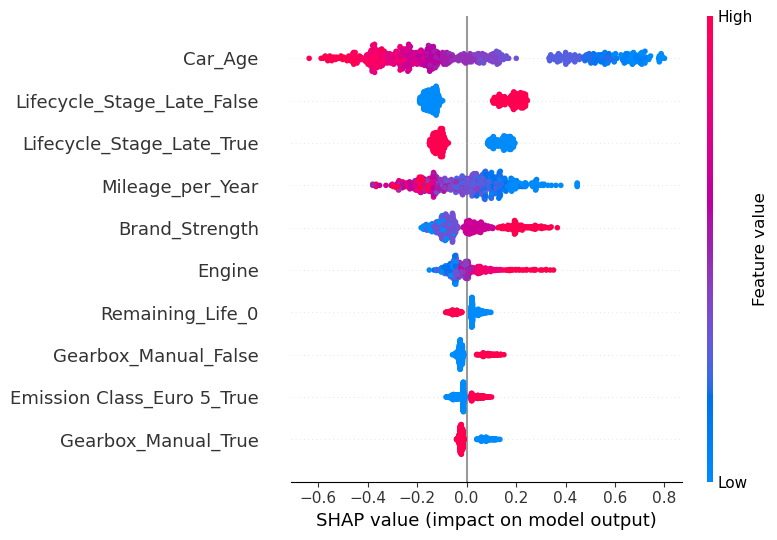

In [11]:

# Create dot-style summary plot
shap.summary_plot(
    shap_values, 
    X_test_preprocessed_df, 
    feature_names=feature_names,
    max_display=10,       # top 10 features
    plot_type='dot'       # dot plot shows positive/negative effect
)

# Model Performance


---- Log-space Metrics ----
MAE (log): 0.1787
RMSE (log): 0.2845
R² (log): 0.8739

---- Actual-space Metrics ----
MAE ($): 770.26
RMSE ($): 1340.01
R²: 0.9157


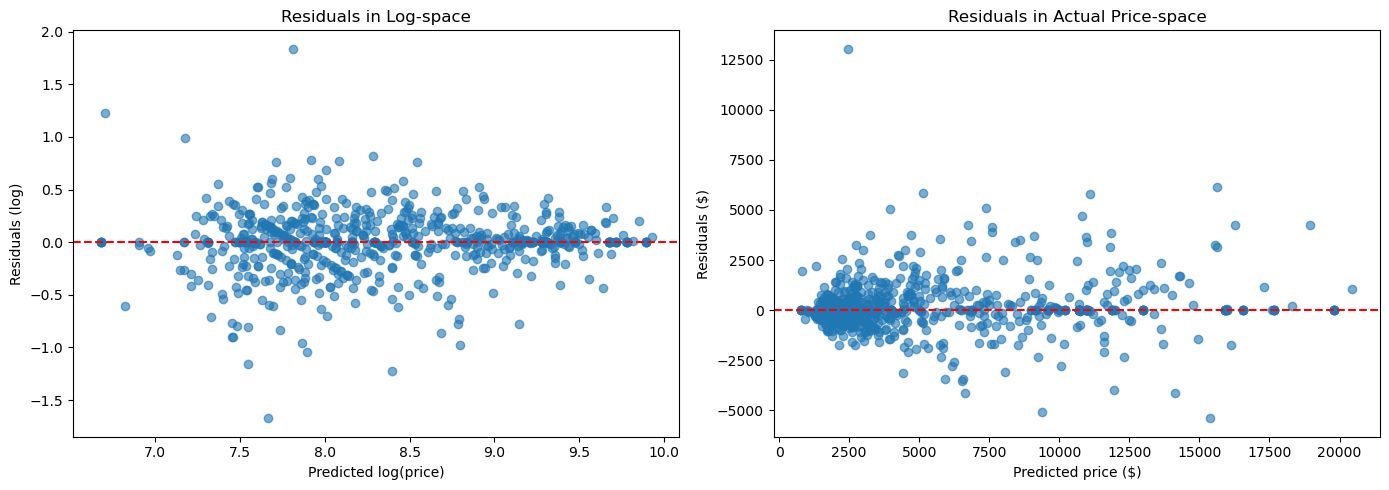

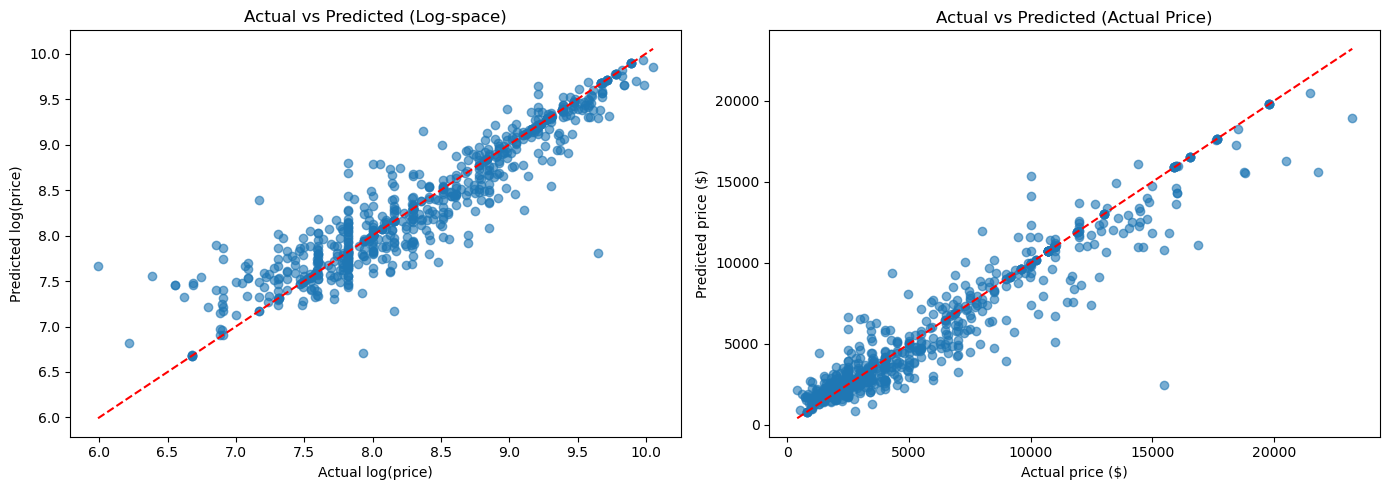

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -----------------------------
# Make predictions
# -----------------------------
y_pred_log = rf_model.predict(X_test_preprocessed)  # model predicts log(y) if you trained on log
y_test_log = y_test  # assuming y_test is log-transformed

# Inverse-transform to actual price
y_pred_actual = np.exp(y_pred_log)  # natural log inverse
y_test_actual = np.exp(y_test_log)

# -----------------------------
# 1️⃣ Metrics in log-space
# -----------------------------
mae_log = mean_absolute_error(y_test_log, y_pred_log)
rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_log))
r2_log = r2_score(y_test_log, y_pred_log)

print("---- Log-space Metrics ----")
print(f"MAE (log): {mae_log:.4f}")
print(f"RMSE (log): {rmse_log:.4f}")
print(f"R² (log): {r2_log:.4f}")

# -----------------------------
# 2️⃣ Metrics in actual price-space
# -----------------------------
mae_actual = mean_absolute_error(y_test_actual, y_pred_actual)
rmse_actual = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
r2_actual = r2_score(y_test_actual, y_pred_actual)

print("\n---- Actual-space Metrics ----")
print(f"MAE ($): {mae_actual:.2f}")
print(f"RMSE ($): {rmse_actual:.2f}")
print(f"R²: {r2_actual:.4f}")

# -----------------------------
# 3️⃣ Residual plots
# -----------------------------
residuals_log = y_test_log - y_pred_log
residuals_actual = y_test_actual - y_pred_actual

fig, axes = plt.subplots(1, 2, figsize=(14,5))

# Log-space residuals
axes[0].scatter(y_pred_log, residuals_log, alpha=0.6)
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_xlabel("Predicted log(price)")
axes[0].set_ylabel("Residuals (log)")
axes[0].set_title("Residuals in Log-space")

# Actual-space residuals
axes[1].scatter(y_pred_actual, residuals_actual, alpha=0.6)
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_xlabel("Predicted price ($)")
axes[1].set_ylabel("Residuals ($)")
axes[1].set_title("Residuals in Actual Price-space")

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(14,5))

# Log-space
axes[0].scatter(y_test_log, y_pred_log, alpha=0.6)
axes[0].plot([y_test_log.min(), y_test_log.max()],
             [y_test_log.min(), y_test_log.max()],
             'r--')
axes[0].set_xlabel("Actual log(price)")
axes[0].set_ylabel("Predicted log(price)")
axes[0].set_title("Actual vs Predicted (Log-space)")

# Actual-space
axes[1].scatter(y_test_actual, y_pred_actual, alpha=0.6)
axes[1].plot([y_test_actual.min(), y_test_actual.max()],
             [y_test_actual.min(), y_test_actual.max()],
             'r--')
axes[1].set_xlabel("Actual price ($)")
axes[1].set_ylabel("Predicted price ($)")
axes[1].set_title("Actual vs Predicted (Actual Price)")

plt.tight_layout()
plt.show()

## Residual Analysis

**Log-space residuals:** The residuals are fairly evenly scattered around zero with no obvious trend, indicating that the model fits the log-transformed target reasonably well. Most predictions are close to the true log-values, and there are no extreme systematic biases.

**Actual-price residuals:** The residuals in dollars show more spread, especially for higher-priced cars. This is expected because the model was trained on log-transformed prices — errors in log-space translate to larger dollar errors for more expensive cars. Some outliers exist, likely representing high-priced vehicles where the model underestimates or overestimates slightly.

**Interpretation:**
Overall, the model is capturing the main patterns of car pricing well.
Large deviations for expensive cars are a known effect of log-transforming targets, and could be reduced with more data for high-priced cars or specialized models.

## Predictive Accuracy

The combination of SHAP plots and residuals suggests good predictive performance:

- Most predictions lie close to the 45° line in actual vs predicted plots.
- No strong heteroscedasticity is visible in log-space, which validates the choice of log transformation.

## Feature Insights (SHAP Analysis)


### SHAP Summary Plot (impact on output)

Top positive/negative drivers of price:
Car_Age: The most important feature; newer cars (low age) push predicted prices higher, older cars lower.
Lifecycle Stage: Late-stage cars (Lifecycle_Stage_Late_True/False) significantly affect price — newer lifecycle stages increase value, later stages decrease it.
Mileage_per_Year: Higher mileage reduces price; lower mileage increases price.
Brand_Strength: Stronger brands positively influence car value.
Engine: Larger engine size slightly increases price.


### SHAP Feature Importance (bar plot)

**Confirms the ranking of features:**

- Car_Age — dominates impact on price.
- Lifecycle Stage — early vs late stage has strong effect.
- Mileage_per_Year — a key negative driver.
- Brand_Strength — differentiates premium from standard cars.
- Engine and other categorical features — moderate impact.

**Interpretation:**

- The model aligns with real-world expectations: newer cars with strong brands, lower mileage, and better lifecycle stage command higher prices.
- Categorical features like gearbox type and emission class have minor effects but still contribute to predictions.

# Key Takeaways

**Performance:**

- Model fits log-prices well, translating into reasonable predictions in actual prices.
- Residuals show good randomness around zero, suggesting no major systematic bias.

**Drivers of car price:**

- Age, lifecycle stage, mileage, and brand strength are the strongest determinants.
- Engine size and gearbox type have secondary influence.
- Potential Improvements:
- For expensive cars, consider additional features or specialized models to reduce large residuals.
Explore interaction terms (e.g., Age × Mileage) for subtle patterns.